In [1]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset
from tqdm import tqdm
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import defaultdict
from math import log2
tqdm.pandas()
from surprise import NMF
from sklearn.utils import resample

In [2]:
# Load and filter data
interactions = pd.read_pickle('../Pickle/interactions.pkl')
books = pd.read_pickle('../Pickle/books.pkl')
imputed = pd.read_pickle('../Pickle/imputed_ratings.pkl')
interactions = interactions[['user_id', 'book_id', 'rating', 'is_read']]  

In [3]:
interactions = interactions[interactions['rating'] != 0]
frames = [interactions, imputed]
interactions = pd.concat(frames)

In [4]:
def split_data_with_single_interactions(df):
    # Identify users and books that appear only once in the dataset
    user_counts = df['user_id'].value_counts()
    book_counts = df['book_id'].value_counts()

    # Find interactions where user or book appears only once
    single_interactions = df[
        df['user_id'].isin(user_counts[user_counts == 1].index) | 
        df['book_id'].isin(book_counts[book_counts == 1].index)
    ]

    # Remove those interactions from the main dataset
    remaining_interactions = df[~df.index.isin(single_interactions.index)]

    # Split the remaining interactions into train and test using sklearn's train_test_split
    train_df, test_df = train_test_split(remaining_interactions, test_size=0.2, random_state=42, stratify=remaining_interactions['rating'])

    # Add the single interactions to the training set
    train_df = pd.concat([train_df, single_interactions], ignore_index=True)


    return train_df, test_df

train_df, test_df = split_data_with_single_interactions(interactions)

In [ ]:
rating_counts = train_df['rating'].value_counts()

# Find the majority class size (highest count)
majority_count = rating_counts.max()

MAX_TARGET_SIZE = int(0.75 * majority_count)

modified_dfs = []

# Perform upsampling with slight noise addition for each class
for rating, count in rating_counts.items():
    class_df = train_df[train_df['rating'] == rating]

    if count >= MAX_TARGET_SIZE:
        balanced_df = class_df.copy()
    else:
        balanced_df = resample(class_df,
                               replace=True,
                               n_samples=MAX_TARGET_SIZE,
                               random_state=42)

        # Add random noise to the ratings
        balanced_df['rating'] = balanced_df['rating'] + np.random.uniform(-0.1, 0.1, size=balanced_df.shape[0])
        # Ensure ratings are within the valid range (e.g., between 1 and 5)
        balanced_df['rating'] = balanced_df['rating'].clip(1, 5)

    modified_dfs.append(balanced_df)


balanced_train = pd.concat(modified_dfs, ignore_index=True)

# Shuffle dataset
train_df = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# Log scale ratings
def normalise_ratings(train_data, test_data):
    min_rating = train_data['rating'].min()
    
    if min_rating < 0:
        train_data['rating'] = train_data['rating'] - min_rating
        test_data['rating'] = test_data['rating'] - min_rating

    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])

    return train_data, test_data, min_rating


def denormalize_rating(log_scaled_ratings, min_rating):
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)

    # Reverse log1p transformation
    original_ratings = np.expm1(log_scaled_ratings)

    # Adjust for minimum rating
    if min_rating:
        original_ratings += min_rating

    # Clip values between 0 and 5
    return np.clip(original_ratings, 0, 5)

In [7]:
train_df, test_df, min_rating = normalise_ratings(train_df, test_df)

In [8]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)

In [ ]:
# Define the parameter grid
param_grid = { 
    'n_factors': [50],  
    'n_epochs': [200],  
    'reg_pu': [0.01],  # Regularization for user factors
    'reg_qi': [0.01],  # Regularization for item factors
    'lr_bu': [0.01],  # Learning rate for user bias
    'lr_bi': [0.01],  # Learning rate for item bias
    'random_state': [42]
}

gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=2)

gs.fit(train_data)

best_params = gs.best_params['rmse']
best_nmf = NMF(**best_params, verbose = True)

print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best MAE: {gs.best_score['mae']:.4f}")


print(f"Best Parameters: {best_params}")

Best RMSE: 0.2233
Best RMSE: 0.1591
Best Parameters: {'n_factors': 50, 'n_epochs': 200, 'reg_pu': 0.01, 'reg_qi': 0.01, 'lr_bu': 0.01, 'lr_bi': 0.01, 'random_state': 42}


In [22]:
trainset = train_data.build_full_trainset()
testset = [tuple(x) for x in test_df[['user_id', 'book_id', 'rating']].values]
best_nmf.fit(trainset)
predictions = best_nmf.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [23]:
import joblib
joblib.dump(best_nmf, '../Pickle/best_nmf_model.pkl')

['../Pickle/best_nmf_model.pkl']

In [24]:
predictions

[Prediction(uid=1611.0, iid=39335.0, r_ui=1.791759469228055, est=1.766592833808677, details={'was_impossible': False}),
 Prediction(uid=433.0, iid=97061.0, r_ui=1.6094379124341003, est=1.1114325022226055, details={'was_impossible': False}),
 Prediction(uid=1920.0, iid=29297.0, r_ui=1.3862943611198906, est=1.412007848072086, details={'was_impossible': False}),
 Prediction(uid=901.0, iid=7895.0, r_ui=1.791759469228055, est=1.6403948804987845, details={'was_impossible': False}),
 Prediction(uid=739.0, iid=1259.0, r_ui=1.6094379124341003, est=1.66055618953079, details={'was_impossible': False}),
 Prediction(uid=1412.0, iid=51094.0, r_ui=1.791759469228055, est=1.7572967637655008, details={'was_impossible': False}),
 Prediction(uid=1894.0, iid=75965.0, r_ui=1.6094379124341003, est=1.523814460485556, details={'was_impossible': False}),
 Prediction(uid=1524.0, iid=5236.0, r_ui=1.6094379124341003, est=1.664225476552263, details={'was_impossible': False}),
 Prediction(uid=435.0, iid=97471.0, r_u

In [25]:
def precision_recall_ndcg_mrr_at_k(predictions, min_rating, k, threshold):
    denormalized_ratings = [denormalize_rating(est, min_rating) for _, _, _, est, _ in predictions]
    denormalized_true_ratings = [denormalize_rating(true_r, min_rating) for _, _, true_r, _, _ in predictions]

    denormalized_predictions = [(uid, iid, denormalized_true_ratings[idx], denormalized_ratings[idx], _) 
                                for idx, (uid, iid, true_r, est, _) in enumerate(predictions)]

    # Organise predictions by user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in denormalized_predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions, recalls, ndcgs, mrrs = [], [], [], []

    for user_id, user_ratings in user_est_true.items():
        # Sort by estimated rating
        user_ratings.sort(key=lambda x: x[1], reverse=True)

        # Get relevant items (ratings >= threshold)
        relevant_items = [(iid, est, true_r) for iid, est, true_r in user_ratings if true_r >= threshold]
        n_rel = len(relevant_items)

        if n_rel == 0:
            precisions.append(0)
            recalls.append(0)
            ndcgs.append(0)
            mrrs.append(0)
            continue

        # Get top-k predictions
        top_k = user_ratings[:k]
        n_rec_k = sum(est >= threshold for _, est, _ in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for _, est, true_r in top_k)

        # Precision at k
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k > 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel > 0 else 0

        # NDCG at k
        actual_dcg = sum((2 ** rel - 1) / log2(idx + 2) for idx, (_, _, rel) in enumerate(top_k))
        ideal_ratings_sorted = sorted(user_ratings, key=lambda x: x[2], reverse=True)[:k]
        ideal_dcg = sum((2 ** rel - 1) / log2(idx + 2) for idx, (_, _, rel) in enumerate(ideal_ratings_sorted))
        ndcg = actual_dcg / ideal_dcg if ideal_dcg > 0 else 0

        # MRR at k
        mrr = 0
        for rank, (iid, est, true_r) in enumerate(top_k, start=1):
            if true_r >= threshold:
                mrr = 1 / rank
                break

        # Append the metrics
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        mrrs.append(mrr)

    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(ndcgs),
        np.mean(mrrs)
    )

k = 5
precisions, recalls, ndcgs, mrrs = precision_recall_ndcg_mrr_at_k(predictions, min_rating, k, 4)
print(f'Precision@{k}: {precisions:.4f}, Recall@{k}: {recalls:.4f}, nDCG@{k}: {ndcgs:.4f}, MRR@@{k}: {mrrs:.4f} ')

Precision@5: 0.9575, Recall@5: 0.3665, nDCG@5: 0.9177, MRR@@5: 0.9851 


In [26]:
def precision_recall_ndcg_mrr_at_k(predictions, min_rating, k, threshold, item_popularity, num_users):
    """
    Compute Precision@k, Recall@k, nDCG@k, MRR@k, Novelty, Hit Rate, and User Coverage.

    Parameters:
        predictions (list): List of tuples (user_id, item_id, true_rating, predicted_rating, _).
        min_rating (float): Minimum rating value for denormalization.
        k (int): Number of recommendations to consider.
        threshold (float): Threshold for considering an item as relevant.
        item_popularity (dict): Dictionary of item popularity counts.
        num_users (int): Total number of users.

    Returns:
        Tuple of (precision, recall, ndcg, mrr, novelty, hit_rate, user_coverage).
    """
    # Denormalize ratings
    denormalized_ratings = [denormalize_rating(est, min_rating) for _, _, _, est, _ in predictions]
    denormalized_true_ratings = [denormalize_rating(true_r, min_rating) for _, _, true_r, _, _ in predictions]

    denormalized_predictions = [(uid, iid, denormalized_true_ratings[idx], denormalized_ratings[idx], _) 
                                for idx, (uid, iid, true_r, est, _) in enumerate(predictions)]

    # Organize predictions by user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in denormalized_predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions, recalls, ndcgs, mrrs = [], [], [], []
    hit_counts = defaultdict(int)  # Track hits for Hit Rate
    user_coverage_set = set()  # Track users with at least one recommendation
    novelty_scores = []  # Track novelty scores

    max_self_info = log2(num_users) if num_users > 0 else 1  # Avoid division by zero

    for user_id, user_ratings in user_est_true.items():
        # Sort by estimated rating
        user_ratings.sort(key=lambda x: x[1], reverse=True)

        # Get relevant items (ratings >= threshold)
        relevant_items = [(iid, est, true_r) for iid, est, true_r in user_ratings if true_r >= threshold]
        n_rel = len(relevant_items)

        if n_rel == 0:
            precisions.append(0)
            recalls.append(0)
            ndcgs.append(0)
            mrrs.append(0)
            continue

        # Get top-k predictions
        top_k = user_ratings[:k]
        n_rec_k = sum(est >= threshold for _, est, _ in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for _, est, true_r in top_k)

        # Precision at k
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k > 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel > 0 else 0

        # NDCG at k
        actual_dcg = sum((2 ** rel - 1) / log2(idx + 2) for idx, (_, _, rel) in enumerate(top_k))
        ideal_ratings_sorted = sorted(user_ratings, key=lambda x: x[2], reverse=True)[:k]
        ideal_dcg = sum((2 ** rel - 1) / log2(idx + 2) for idx, (_, _, rel) in enumerate(ideal_ratings_sorted))
        ndcg = actual_dcg / ideal_dcg if ideal_dcg > 0 else 0

        # MRR at k
        mrr = 0
        for rank, (iid, est, true_r) in enumerate(top_k, start=1):
            if true_r >= threshold:
                mrr = 1 / rank
                break

        # Hit Rate
        if n_rel_and_rec_k > 0:
            hit_counts[user_id] = 1

        # User Coverage
        if n_rec_k > 0:
            user_coverage_set.add(user_id)

        # Novelty (normalized to 0-1)
        raw_self_info = [-log2(item_popularity.get(iid, 1) / num_users) for iid, _, _ in top_k]
        normalized_self_info = [score / max_self_info for score in raw_self_info]
        mean_self_info = np.mean(normalized_self_info)
        novelty_scores.append(mean_self_info)

        # Append the metrics
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        mrrs.append(mrr)

    # Compute overall metrics
    precision = np.mean(precisions)
    recall = np.mean(recalls)
    ndcg = np.mean(ndcgs)
    mrr = np.mean(mrrs)
    hit_rate = np.mean(list(hit_counts.values())) if hit_counts else 0
    user_coverage = len(user_coverage_set) / len(user_est_true) if user_est_true else 0
    novelty = np.mean(novelty_scores) if novelty_scores else 0

    return (
        precision,
        recall,
        ndcg,
        mrr,
        novelty,
        hit_rate,
        user_coverage
    )

threshold = 4  # Relevance threshold
item_popularity = test_df['book_id'].value_counts().to_dict()
num_users = test_df['user_id'].nunique()

# Compute metrics
precision, recall, ndcg, mrr, novelty, hit_rate, user_coverage = precision_recall_ndcg_mrr_at_k(
    predictions, min_rating=1.0, k=k, threshold=threshold, item_popularity=item_popularity, num_users=num_users
)

# Print results
print(f'Precision@{k}: {precision:.4f}')
print(f'Recall@{k}: {recall:.4f}')
print(f'nDCG@{k}: {ndcg:.4f}')
print(f'MRR@{k}: {mrr:.4f}')
print(f'Novelty: {novelty:.4f}')
print(f'Hit Rate: {hit_rate:.4f}')
print(f'User Coverage: {user_coverage:.4f}')


Precision@5: 0.9575
Recall@5: 0.3665
nDCG@5: 0.9177
MRR@5: 0.9851
Novelty: 0.7604
Hit Rate: 1.0000
User Coverage: 0.9850


In [27]:
est_ratings = np.array([pred.est for pred in predictions], dtype=float)
true_ratings = np.array([pred.r_ui for pred in predictions], dtype=float)
true_ratings = denormalize_rating(true_ratings, min_rating)
est_ratings = denormalize_rating(est_ratings, min_rating)

In [28]:
true_ratings.mean()

4.605384477931979

In [29]:
est_ratings.mean()

4.453036632694276

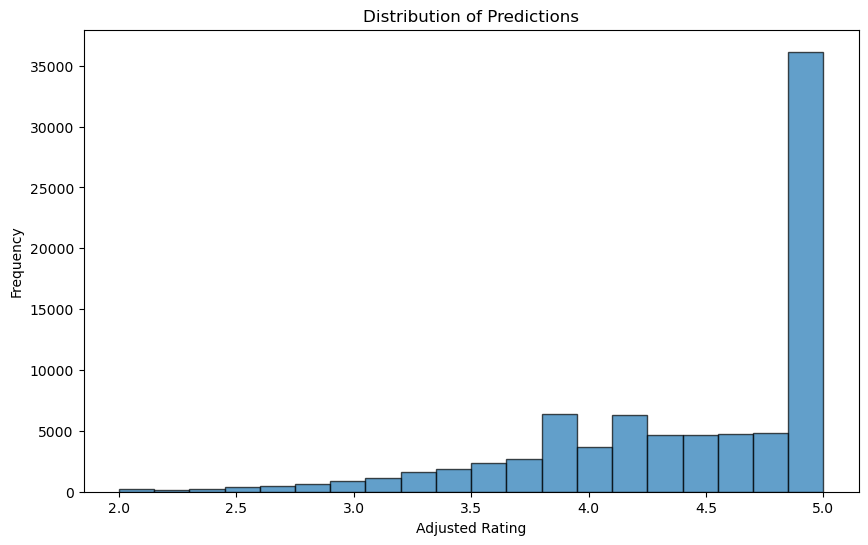

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(est_ratings, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()

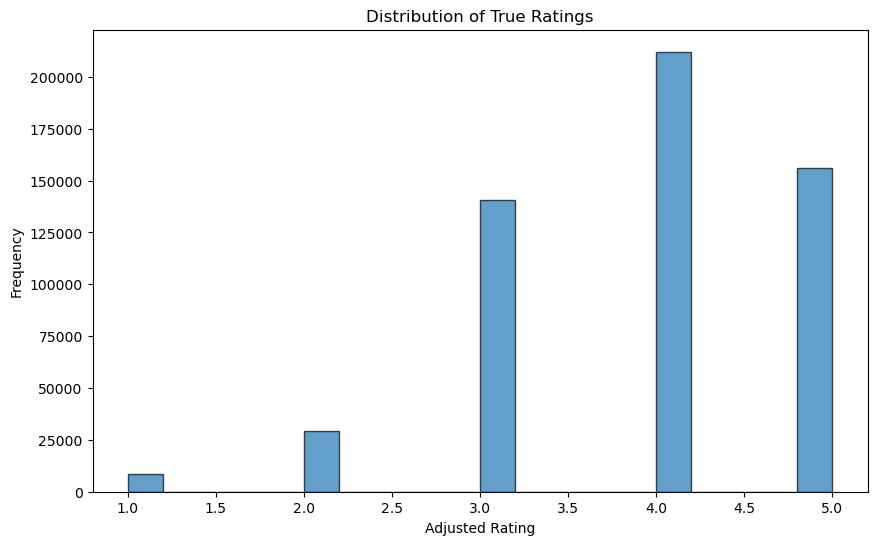

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(interactions['rating'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of True Ratings')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()

In [33]:
# After fitting your best_nmf model
pu = best_nmf.pu  # user latent features (users x factors)
qi = best_nmf.qi  # item latent features (items x factors)


In [ ]:

user_idx = 1611  # Internal user id (depends on Surprise’s inner mapping)
item_idx = 39335 # Internal item id (depends on Surprise’s inner mapping)

user_factors = pu[user_idx]
item_factors = qi[item_idx]

# Compute element-wise contributions
contributions = user_factors * item_factors
predicted_rating = contributions.sum()

# Get indices of the top 5 absolute contributions
top_5_indices = np.argsort(np.abs(contributions))[::-1][:5]

# Print the top 5 contributions
print(f"Top 5 contributing latent factors for prediction (user {user_idx} and item {item_idx}):\n")

for rank, i in enumerate(top_5_indices, 1):
    print(f"{rank}. Latent Factor {i+1}: User affinity {user_factors[i]:.3f} * "
          f"Item relevance {item_factors[i]:.3f} = {contributions[i]:.3f}")

Top 5 contributing latent factors for prediction (user 1611 and item 39335):

1. Latent Factor 33: User affinity 0.270 * Item relevance 0.407 = 0.110
2. Latent Factor 46: User affinity 0.328 * Item relevance 0.261 = 0.085
3. Latent Factor 41: User affinity 0.260 * Item relevance 0.323 = 0.084
4. Latent Factor 49: User affinity 0.302 * Item relevance 0.212 = 0.064
5. Latent Factor 31: User affinity 0.242 * Item relevance 0.200 = 0.048


In [42]:
import pickle
books_list = []
with open('../Pickle/books.pkl', 'rb') as file:
    while True:
        try:
            chunk = pickle.load(file)
            books_list.append(chunk)
        except EOFError:
            break  
books = pd.concat(books_list, ignore_index=True)
books = books.drop_duplicates(subset='title', keep='first')

In [ ]:
# Assuming 'books' dataframe has a column 'book_id' and 'title'

# Define the top N contributing latent factors to retrieve
top_n = 5

# Find the top N contributing latent factors (based on the contribution values)
top_factors_idx = contributions.argsort()[-top_n:][::-1]

# Mapping internal model indices to original book_id
# Assuming your books dataframe has a column 'book_id' and the model's internal indices match the order of your 'books' dataframe
book_id_from_idx = books.iloc[item_idx]['book_id']  # Get the book_id using internal index

# Now you can map the internal indices to the original book titles
for i in top_factors_idx:
    # Get the corresponding book index (item_idx)
    book_id = books.iloc[i]['book_id']  # Internal index in the model maps to the original book_id
    book_title = books.loc[books['book_id'] == book_id, 'title'].values[0]
    
    print(f"Latent Factor {i+1}: User affinity {user_factors[i]:.3f} * Item relevance {item_factors[i]:.3f} = {contributions[i]:.3f}")
    print(f"Book: {book_title}\n")


Latent Factor 33: User affinity 0.270 * Item relevance 0.407 = 0.110
Book: The Black Mass of Brother Springer

Latent Factor 46: User affinity 0.328 * Item relevance 0.261 = 0.085
Book: Tropic of Cancer

Latent Factor 41: User affinity 0.260 * Item relevance 0.323 = 0.084
Book: The Puffin Book Of Nonsense Verse

Latent Factor 49: User affinity 0.302 * Item relevance 0.212 = 0.064
Book: The Lover

Latent Factor 31: User affinity 0.242 * Item relevance 0.200 = 0.048
Book: A Shadow in Summer (Long Price Quartet, #1)

Predicted rating (before denormalisation): 1.085
